In [1]:
from PIL import Image
from numpy import *
from pylab import *
import numpy as np

In [2]:
import camera
import homography
import sfm
import sift
camera = reload(camera)
homography = reload(homography)
sfm = reload(sfm)
sift = reload(sift)

In [3]:
# Read features
im1 = array(Image.open('images/001.jpg'))
sift.process_image('images/001.jpg', 'im1.sift')
l1, d1 = sift.read_features_from_file('im1.sift')

im2 = array(Image.open('images/003.jpg'))
sift.process_image('images/003.jpg', 'im2.sift')
l2, d2 = sift.read_features_from_file('im2.sift')

processed tmp.pgm to im1.sift
processed tmp.pgm to im2.sift


In [9]:
matches = sift.match_twosided(d1, d2)

In [10]:
ndx = matches.nonzero()[0]
x1 = homography.make_homog(l1[ndx, :2].T)
ndx2 = [int(matches[i]) for i in ndx]
x2 = homography.make_homog(l2[ndx2, :2].T)

x1n = x1.copy()
x2n = x2.copy()

In [11]:
print len(ndx)

841


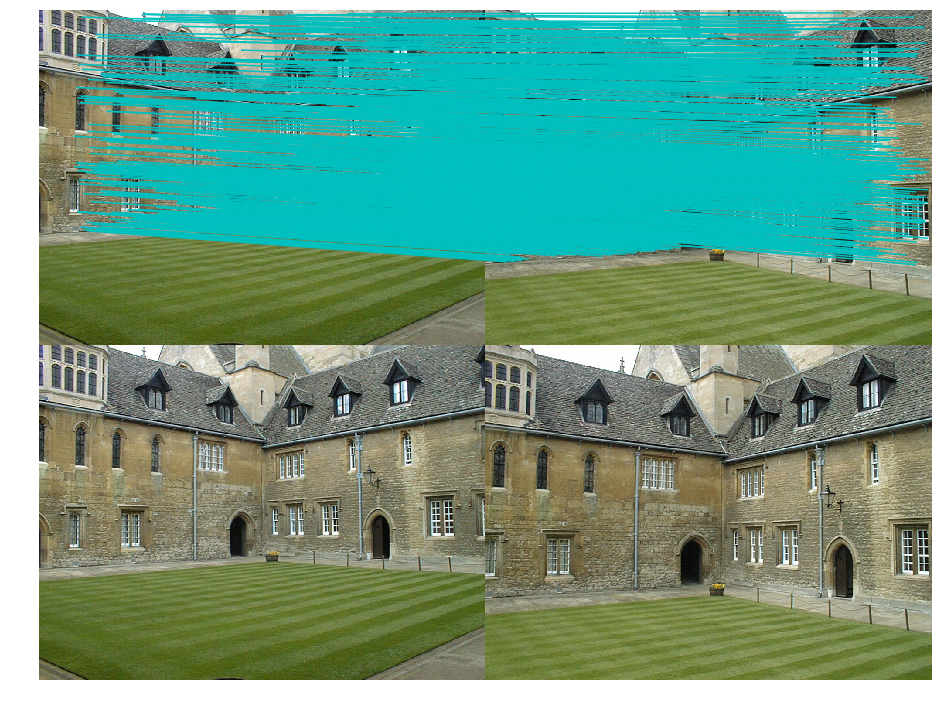

In [12]:
figure(figsize=(16,16))
sift.plot_matches(im1, im2, l1, l2, matches, True)
show()

In [13]:
# Chapter 5 Exercise 1
# Don't use K1, and K2

#def F_from_ransac(x1, x2, model, maxiter=5000, match_threshold=1e-6):
def F_from_ransac(x1, x2, model, maxiter=5000, match_threshold=1e-6):
    """ Robust estimation of a fundamental matrix F from point
    correspondences using RANSAC (ransac.py from
    http://www.scipy.org/Cookbook/RANSAC).

    input: x1, x2 (3*n arrays) points in hom. coordinates. """

    import ransac
    data = np.vstack((x1, x2))
    d = 20 # 20 is the original
    # compute F and return with inlier index
    F, ransac_data = ransac.ransac(data.T, model,
                                   8, maxiter, match_threshold, d, return_all=True)
    return F, ransac_data['inliers']

In [15]:
# find E through RANSAC
model = sfm.RansacModel()
F, inliers = F_from_ransac(x1n, x2n, model, maxiter=5000, match_threshold=1e-4)

In [16]:
print len(x1n[0])
print len(inliers)

841
50


In [17]:
P1 = array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2 = sfm.compute_P_from_fundamental(F)

In [18]:
# triangulate inliers and remove points not in front of both cameras
X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2)

In [19]:
# plot the projection of X
cam1 = camera.Camera(P1)
cam2 = camera.Camera(P2)
x1p = cam1.project(X)
x2p = cam2.project(X)

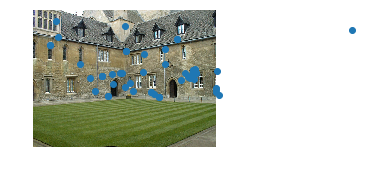

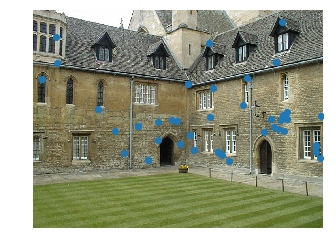

In [20]:
figure()
imshow(im1)
gray()
plot(x1p[0], x1p[1], 'o')
#plot(x1[0], x1[1], 'r.')
axis('off')

figure()
imshow(im2)
gray()
plot(x2p[0], x2p[1], 'o')
#plot(x2[0], x2[1], 'r.')
axis('off')
show()

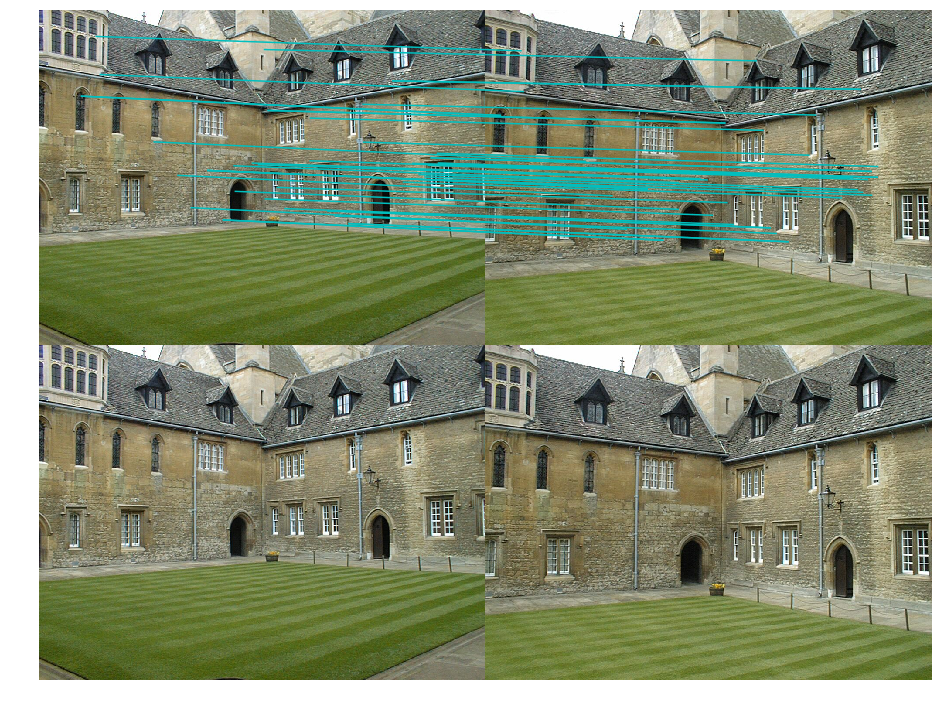

In [21]:
figure(figsize=(16, 16))
im3 = sift.appendimages(im1, im2)
im3 = vstack((im3, im3))

imshow(im3)

cols1 = im1.shape[1]
rows1 = im1.shape[0]
for i in range(len(x1p[0])):
    if (0<= x1p[0][i]<cols1) and (0<= x2p[0][i]<cols1) and (0<=x1p[1][i]<rows1) and (0<=x2p[1][i]<rows1):
        plot([x1p[0][i], x2p[0][i]+cols1],[x1p[1][i], x2p[1][i]],'c')
axis('off')
show()

In [22]:
print F

[[  5.95696436e-07   1.64227815e-05  -2.41989737e-03]
 [ -1.27132581e-05  -8.09530629e-08   3.09001431e-02]
 [  3.12174614e-04  -2.97058942e-02   1.00000000e+00]]


In [23]:
# Chapter 5 Exercise 2

x1e = []
x2e = []
ers = []
for i,m in enumerate(matches):
    if m>0: #plot([locs1[i][0],locs2[m][0]+cols1],[locs1[i][1],locs2[m][1]],'c')
        p1 = array([l1[i][0], l1[i][1], 1])
        p2 = array([l2[m][0], l2[m][1], 1])
        # Use Sampson distance as error
        Fx1 = dot(F, p1)
        Fx2 = dot(F, p2)
        denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
        e = (dot(p1.T, dot(F, p2)))**2 / denom
        x1e.append([p1[0], p1[1]])
        x2e.append([p2[0], p2[1]])
        ers.append(e)
x1e = array(x1e)
x2e = array(x2e)
ers = array(ers)

In [24]:
indices = np.argsort(ers)
x1s = x1e[indices]
x2s = x2e[indices]
ers = ers[indices]
x1s = x1s[:20]
x2s = x2s[:20]

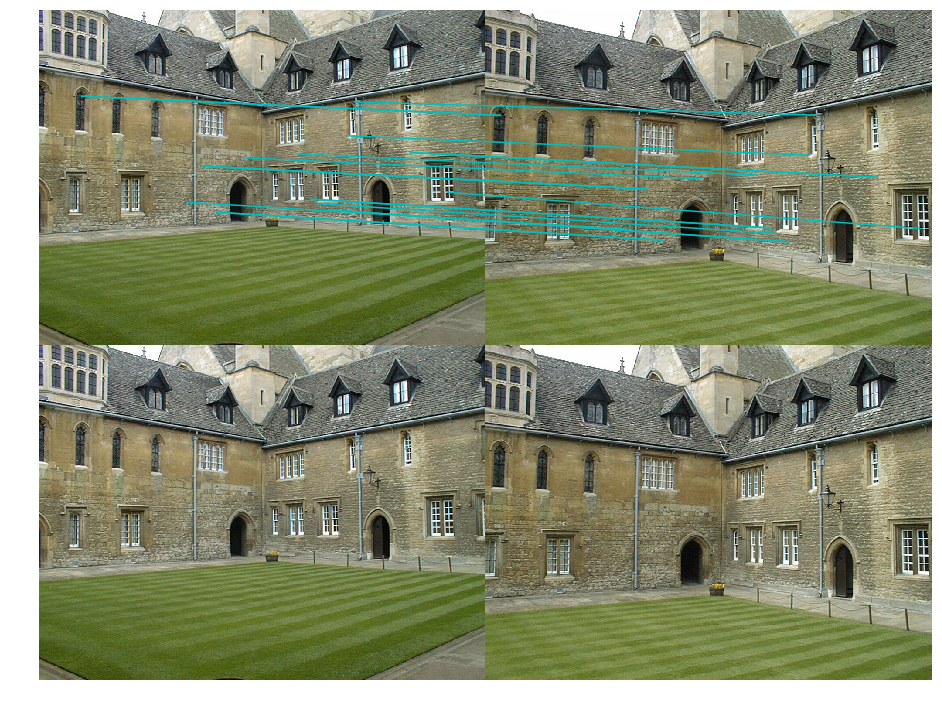

In [25]:
figure(figsize=(16, 16))
im3 = sift.appendimages(im1, im2)
im3 = vstack((im3, im3))

imshow(im3)

cols1 = im1.shape[1]
rows1 = im1.shape[0]
for i in range(len(x1s)):
    if (0<= x1s[i][0]<cols1) and (0<= x2s[i][0]<cols1) and (0<=x1s[i][1]<rows1) and (0<=x2s[i][1]<rows1):
        plot([x1s[i][0], x2s[i][0]+cols1],[x1s[i][1], x2s[i][1]],'c')
axis('off')
show()